Maryland Department of Planning
Property Map Products
https://planning.maryland.gov/Pages/OurProducts/PropertyMapProducts/FinderProduct.aspx
>> Open Data GIS Downloads
MdProperty View
Dorchester
https://planning.maryland.gov/Pages/OurProducts/DownloadFiles.aspx

In [4]:
# !pip install leven
!pip install simpledbf
# !pip install ngram
!pip install seaborn

  Created wheel for simpledbf: filename=simpledbf-0.2.6-cp37-none-any.whl size=13793 sha256=e7136010fc84fcdf6761498d6453b494f62ff87d0d90218b1f4c52b2b792a602
  Stored in directory: /root/.cache/pip/wheels/72/dd/df/cdfb970a508ef9750ebb4b6e035a3410c3d62b5a6a91d2aafc
Successfully built simpledbf


In [5]:
#%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re

from simpledbf import Dbf5
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('drive/My Drive/pita 2021/SDAT-CAN-ref-202105.csv')
can_df = pd.read_csv('drive/My Drive/SDAT/CAN-ref.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,29,45,49,50,52,53,106,112,144) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Build lookup tables for assessmesnts and sqft
https://opendata.maryland.gov/resource/ye3m-tr66.json
https://opendata.maryland.gov/resource/ye3m-tr66.csv

In [8]:
not_digits = re.compile(r'[^0-9\.,]')
#assessments.geo_lat_lon = assessments.geo_lat_lon.apply(lambda x: re.sub(r"^,",'',re.sub(r"[^0-9\.,-]+", "", str(x))))

# fill assessed_value with median where it is missing or zero
med_property_value = df.assessed_value.median()
med_sqft_assessment = df.struct_sqft.median()
med_value_per_sqft = med_property_value/med_sqft_assessment

# try to fill empyt sqft from median value/sqft
def value_sqft(assessed_value,sqft):
  if assessed_value > 0:
    return assessed_value
  elif sqft > 0:
    return sqft * med_value_per_sqft
  else:
    return med_property_value

df.assessed_value = df.apply(lambda x: value_sqft(x.assessed_value,x.struct_sqft), axis = 1)
assessment_lookup = dict(zip(df.acctid, df.assessed_value))
sqft_lookup = dict(zip(df.acctid, df.struct_sqft))


In [9]:
df.assessed_value.quantile([0.25,0.5,0.75])

0.25     19816.5
0.50     84367.0
0.75    174800.0
Name: assessed_value, dtype: float64

In [10]:
#assessments.query('acctid == "1007122225"')
can_df.head()

,acctid,CAN_GROUP,CAN_OWNCLASS,GEOLATLON,GEOHASH
0,1007155603,NaN,COMMERCIAL,"38.55839822712713, -76.07416153313052",dqcgkgk6zw3u
1,1007161174,NaN,COMMERCIAL,"38.572730034552904, -76.07313861641092",dqcgkvvnrqh9
2,1007117892,NaN,COMMERCIAL,"38.55833133614624, -76.07311598366888",dqcgkgm4xcvm
3,1007132581,NaN,HOUSING,"38.56835512643795, -76.06357647998182",dqcgmjhhynqx
4,1007122225,NaN,HOUSING,"38.570440067232006, -76.07000091981125",dqcgkvx90e0j


#### Pull the old CAN information columns

In [13]:
can_df.columns
#can_df = pd.read_csv("drive/My Drive/pita 2020/20191225-can_rental_study_updated.csv")[['ACCTID','CAN_GROUP','CAN_OWNCLASS','GEOLATLON','GEOHASH','LICENSE_TYPE','UNITS']]


Index(['acctid', 'CAN_GROUP', 'CAN_OWNCLASS', 'GEOLATLON', 'GEOHASH'], dtype='object')

#### Get the rental and violation info from the City data

In [11]:
violations_clusters = pd.read_csv('drive/My Drive/pita 2020/violation_clusters.csv')
owners_clusters = pd.read_csv('drive/My Drive/pita 2020/rental_clusters.csv')
owners_clusters.acctid = owners_clusters.acctid.apply(lambda x: str(x).strip())
violations_clusters.APN = violations_clusters.APN.apply(lambda x: str(x).strip())
violations_clusters.rename(columns={'APN':'acctid'},inplace=True)
rental_acctids = owners_clusters.acctid.values


#### Find the accounts that have to be tweaked because of ACCITID problems

There are some larger apt complexes that are now that are subdivided into buildings with separate rental licenses for some reason.

There is at least one property with 2 houses on it too.

In [12]:
can_df.query('acctid not in @rental_acctids and LICENSE_TYPE == "RENTAL"')


UndefinedVariableError: ignored

#### Merge the rental and violation data

<div color='red'>I "FIXED" THIS BY USING THE OUTPUT OF SDAT_ETL.IPYNB TO REPLACE THE OLD CAN_DF -- NEED TO CHECK THIS</div>

In [ ]:
df.acctid = df.acctid.astype(str)
#cluster_df = violations_clusters.merge(owners_clusters.merge(can_df,on='acctid'),on='acctid',how='right')
cluster_df = violations_clusters.merge(owners_clusters.merge(df,on='acctid'),on='acctid',how='right')
cluster_df.contactadd_cluster = cluster_df.contactadd_cluster.fillna(-1)
cluster_df.contact_cluster = cluster_df.contact_cluster.fillna(-1)#cluster_df.violations_total = cluster_df.violations_total.fillna(0)
cluster_df.drop_duplicates(inplace=True)
len(cluster_df) # can_df or rental df less 'dash numbers'
cluster_df

,acctid,contactadd_cluster,contact_cluster,owneradd_cluster,owner_cluster,jurscode,digxcord,digycord,ct2010,bg2010,geogcode,ooi,resityp,address,strtnum,strtdir,strtnam,strttyp,strtsfx,strtunt,addrtyp,city,zipcode,ownname1,ownname2,namekey,ownadd1,ownadd2,owncity,ownstate,ownerzip,ownzip2,premsnum,premsdir,premsnam,premstyp,premcity,premzip,premzip2,legal1,...,nprctstdat,nprcarea,nprcluom,homqlcod,homqldat,bldg_story,bldg_units,resident,resi2010,resi2000,resi1990,resiuths,aprtment,trailer,special,other,ptype,sdatwebadr,existing,mdpvdate,saleid,curlndvl,curimpvl,curttlvl,sallndvl,salimpvl,salttlvl,sdat,google_maps,struct_sqft,assessed_value,address_number,address_unit_id,street_direction,street_name,street_type,premise_address_type_mdp_field_premstyp_sdat_field_24,premise_address_city_mdp_field_premcity_sdat_field_25,premise_address_zip_code_mdp_field_premzip_sdat_field_26,mdp_street_address_mdp_field_address
0,1007104057,-1.0,-1.0,164,174,DORC,481347.2,100263.6,2.401997e+10,2.401997e+11,81,N,SF,304 DORCHESTER AVE,304.0,NaN,DORCHESTER,AVE,NaN,NaN,P,CAMBRIDGE,21613.0,FITZHUGH WILLIAM R &,FITZHUGH WILLIAM R JR,FITZHUGH WILLIAM R &,5522 WHITEHALL RD,NaN,CAMBRIDGE,MD,21613.0,3442.0,304.0,NaN,DORCHESTER,AVE,CAMBRIDGE,21613.0,NaN,IMPSLT 22 AND P/O #21,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,http://sdat.dat.maryland.gov/RealProperty/Page...,MDPV2017_18,2020JUN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.56616379...,1368,93333,1945,304,NaN,NaN,DORCHESTER,AVE,CAMBRIDGE,21613.0,304 DORCHESTER AVE
1,1007104073,234.0,95.0,0,0,DORC,480302.8,99425.4,2.401997e+10,2.401997e+11,81,N,SF,415 SHEPHERD AVE,415.0,NaN,SHEPHERD,AVE,NaN,NaN,P,CAMBRIDGE,21613.0,RUDDY DUCK LLC,NaN,RUDDY DUCK LLC,PO BOX 1181,NaN,CAMBRIDGE,MD,21613.0,NaN,415.0,NaN,SHEPHERD,AVE,CAMBRIDGE,21613.0,NaN,"IMPSLOT 84&85-15,696 SQ.",...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,http://sdat.dat.maryland.gov/RealProperty/Page...,MDPV2017_18,2020JUN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.55870863...,2664,136867,1971,415,NaN,NaN,SHEPHERD,AVE,CAMBRIDGE,21613.0,415 SHEPHERD AVE
2,1007104294,-1.0,-1.0,0,0,DORC,480556.3,99908.5,2.401997e+10,2.401997e+11,81,N,SF,727 PEACHBLOSSOM AVE,727.0,NaN,PEACHBLOSSOM,AVE,NaN,NaN,P,CAMBRIDGE,21613.0,RUDDY DUCK LLC,A MARYLAND LIMITED LIABILITY COMPA,RUDDY DUCK LLC,PO BOX 1181,NaN,CAMBRIDGE,MD,21613.0,NaN,727.0,NaN,PEACHBLOSSOM,AVE,CAMBRIDGE,21613.0,NaN,"IMPSLOT 3,700 SQ. FT.",...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,http://sdat.dat.maryland.gov/RealProperty/Page...,MDPV2017_18,2020JUN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.56303744...,1132,62500,1930,727,NaN,NaN,PEACHBLOSSOM,AVE,CAMBRIDGE,21613.0,727 PEACHBLOSSOM AVE
3,1007104324,-1.0,-1.0,1,1,DORC,480198.9,99773.7,2.401997e+10,2.401997e+11,81,N,SF,900 CENTRAL AVE,900.0,NaN,CENTRAL,AVE,NaN,NaN,P,CAMBRIDGE,21613.0,SHARP MARTIN,NaN,SHARP MARTIN,3723 SWANN RD,NaN,SUITLAND,MD,20746.0,2235.0,900.0,NaN,CENTRAL,AVE,CAMBRIDGE,21613.0,NaN,"IMPSLOT 3,979 SQ. FT.",...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,http://sdat.dat.maryland.gov/RealProperty/Page...,MDPV2017_18,2020JUN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.56185566...,930,48000,1940,900,NaN,NaN,CENTRAL,AVE,CAMBRIDGE,21613.0,900 CENTRAL AVE
4,1007104340,-1.0,-1.0,165,175,DORC,480195.8,99750.0,2.401997e+10,2.401997e+11,81,N,SF,904 CENTRAL AVE,904.0,NaN,CENTRAL,AVE,NaN,NaN,P,CAMBRIDGE,21613.0,NEWCOMB JAMES C JR AND ETAL,NEWCOMB JOYCE A,NEWCOMB JAMES C JR AND ET,906 CENTRAL AVENUE,NaN,CAMBRIDGE,MD,21613.0,2724.0,904.0,NaN,CENTRAL,AVE,CAMBRIDGE,21613.0,NaN,"IMPSLOT 4,000 SQ. FT.",...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0

#### Merge the sdat with the city data

In [ ]:
# cluster_df = cluster_df.merge(pd.Series(clusters.labels_,name='cluster'),left_index=True,right_index=True,how='inner')
interesting_columns = ['acctid','address','nfmttlvl','ownname1','ownadd1','ownname2','ownadd2','ownerzip','namekey','yearblt']
analysis_columns = ['CAN_GROUP','acctid','address','owner_cluster','ownname1','owneradd_cluster','ownadd1','ownerzip','contactadd_cluster','contact_cluster','ownname2','ownadd2','namekey','yearblt']
#results = cluster_df.merge(df[interesting_columns],on='acctid',how='inner')[analysis_columns]
results = cluster_df[analysis_columns]

KeyError: ignored

In [ ]:
results.query('acctid == "1007120532"')

,CAN_GROUP,acctid,address,owner_cluster,ownname1,owneradd_cluster,ownadd1,ownerzip,contactadd_cluster,contact_cluster,ownname2,ownadd2,namekey,yearblt
235,TALBOT,1007120532,300 E APPLEBY AVE,710,MEREDITH JAMES WESLEY II,635,4414 BUCKTOWN RD,21613,129.0,130.0,WOOTEN DENNIS JORDAN,NaN,MEREDITH JAMES WESLEY II,1945


### Cluster the acctid's by owner

Make a graph of the acctid's jointed by owner clusters numbers from previous processing.

The violation data can be used to join the clusters further, but not at the moment...

In [ ]:
import networkx as nx
from itertools import permutations

owneraddedges = results[['acctid','owneradd_cluster']].query('owneradd_cluster != "-1"').groupby('owneradd_cluster')['acctid'].apply(list)
owneradd_mostcommon = results.query('owneradd_cluster != "-1"').groupby(['owneradd_cluster'])['ownadd1'].agg(lambda x:x.value_counts().index[0]).to_dict()
owneredges = results[['acctid','owner_cluster']].query('owner_cluster != "-1"').groupby('owner_cluster')['acctid'].apply(list)
owner_mostcommon = results.query('owner_cluster != "-1"').groupby(['owner_cluster'])['ownname1'].agg(lambda x:x.value_counts().index[0]).to_dict()

contactaddedges = results[['acctid','contactadd_cluster']].query('contactadd_cluster != "-1"').groupby('contactadd_cluster')['acctid'].apply(list)
contactadd_mostcommon = results.query('contactadd_cluster != "-1"').groupby(['contactadd_cluster'])['ownname1'].agg(lambda x:x.value_counts().index[0]).to_dict()
contactdges = results[['acctid','contact_cluster']].query('contact_cluster != "-1"').groupby('contact_cluster')['acctid'].apply(list)
contact_mostcommon = results.query('contact_cluster != "-1"').groupby(['contact_cluster'])['ownname1'].agg(lambda x:x.value_counts().index[0]).to_dict()

#print(contactadd_mostcommon['ownname1'])
F = nx.Graph()

def add_cluster_edges(G,edgeinfo,attrmap,cluster_number_col,cluster_name_col):
  for cluster,pairs in [(k,[pair for pair in permutations(v,r=2)]) for k,v in edgeinfo.items()]:
    for pair in pairs:
      if len(pair) > 0:
        if not G.has_node(pair[0]):
          G.add_node(pair[0])
        if not G.has_node(pair[1]):
          G.add_node(pair[1])
        G.nodes[pair[0]][cluster_number_col] = cluster
        G.nodes[pair[0]][cluster_name_col] = attrmap[cluster]
        G.nodes[pair[1]][cluster_number_col] = cluster
        G.nodes[pair[1]][cluster_name_col] = attrmap[cluster]
        edge_attrs  = {cluster_number_col:cluster,cluster_name_col:attrmap[cluster]}
        G.add_edge(pair[0],pair[1],**edge_attrs)

add_cluster_edges(F,owneredges,owner_mostcommon,'o_cluster','o_string')
add_cluster_edges(F,owneraddedges,owneradd_mostcommon,'oa_cluster','oa_string')
#add_cluster_edges(F,contactaddedges,contactadd_mostcommon,'contactadd_cluster','contactadd_string')
#add_cluster_edges(F,contactedges,contact_mostcommon,'contact_cluster','contact_string')


#### Build a data frame from the connected components of the graph above, and merge the CAN and assessment data with that

In [ ]:
F.nodes(data=True)
F.nodes['1007160011']
# i=3
# [(k,i,d.get('o_string',d.get('oa_string',"NA"))) for k,d in F.subgraph(c).nodes(data=True) ]
components = sorted(nx.connected_components(F), key = len, reverse=True)

group_df = pd.DataFrame(columns=['acctid','group_id','group_name','GEOLATLON'])
for i,c in enumerate(components):
  group_df = group_df.append(pd.DataFrame([(k,i,d.get('o_string',d.get('oa_string'))) for k,d in F.subgraph(c).nodes(data=True)],columns=['acctid','group_id','group_name']))

keep_columns = ['LICENSE_TYPE','UNITS','CAN_GROUP'] + interesting_columns
group_df = group_df.merge(can_df.merge(df, on='acctid',how='inner')[keep_columns],on='acctid',how='inner')
group_df.nfmttlvl = group_df.apply(lambda x: assessment_lookup.get(x.acctid,x.nfmttlvl),axis=1)
group_df.rename(columns={'nfmttlvl':'assessed_value'},inplace=True)



### Compute the 'quality factor' for each property

This is:
  market_value / log2(age)

where:  
  market_value = x.assessed_value / x.struc_sqft
   / (1+np.log2(this_year - x.yearblt +1)+1)

The $ per sqft is the market assessement of the property quality (

In [ ]:
def get_sqft(struc_sqft,units,med_sqft):
  nominal_units = units if units > 0 else 1
  nominal_sqft = nominal_units * med_sqft if units > 0 else med_sqft
  if struc_sqft > 0 :
    return struc_sqft if struc_sqft > nominal_sqft else nominal_sqft
  else:
    return nominal_sqft

# you need 'struc_sqft' and UNITS per property
def get_quality_factor_lookup(df,default_sqft=0):

  med_sqft = df.struc_sqft.median() if default_sqft == 0 else default_sqft

  df.struc_sqft = df.apply(lambda x: get_sqft(x.struc_sqft,x.UNITS,med_sqft), axis = 1)

  med_yearblt = df.yearblt.median()
  df.yearblt = df.yearblt.fillna(med_yearblt).astype(int)

  import datetime
  this_year = datetime.datetime.now().year

  df['quality_factor'] = df.apply(lambda x: x.assessed_value/x.struc_sqft/(1+np.log10(this_year - x.yearblt +1)+1),axis=1)
  return dict(zip(group_df.acctid, group_df.quality_factor))

group_df['struc_sqft'] = group_df.apply(lambda x: float(sqft_lookup.get(x.acctid,1)),axis=1)
group_quality_lookup = get_quality_factor_lookup(group_df)

pd.set_option('display.max_rows', 60)
group_df[['acctid','UNITS','struc_sqft','yearblt','assessed_value','quality_factor']].sort_values(by='assessed_value')

,acctid,UNITS,struc_sqft,yearblt,assessed_value,quality_factor
197,1007163061,1.0,1120.0,1935,200.0,0.045328
722,1007167040,1.0,1120.0,1920,3600.0,0.801847
174,1007148577,1.0,1120.0,1949,7100.0,1.640889
447,1007128258,1.0,1120.0,1922,8900.0,1.986607
187,1007162995,1.0,1120.0,1916,9100.0,2.018480
...,...,...,...,...,...,...
788,1007210361,24.0,31647.0,2000,2137033.0,20.203067
790,1007286611,24.0,31194.0,2012,2204200.0,23.553675
792,1007286612,36.0,40320.0,2000,2267167.0,16.822929
1060,1007178379,80.0,89600.0,1974,2465600.0,7.475157


### Find all the acctid's that didn't have an edge

These properties do not belong to a group.  It is possible these could be grouped using code violation contact information, or phone numbers of contacts if these are avaiable.

In [ ]:
singles = set(results.acctid.values).difference(set(group_df.acctid.values))
singles_df = results.query('acctid in @singles')
singles_df = can_df[['acctid','LICENSE_TYPE','UNITS','GEOLATLON']].merge(singles_df,on='acctid',how='inner')

#singles_df.query('acctid == "1007196067"').apply(lambda x:get_sqft( float(sqft_lookup.get(str(x.acctid),0)) ,float(x.UNITS)),axis=1)
#sqft_lookup.get("1007196067",0)
#get_sqft(9022.0,96.0)

In [ ]:
# missing 'LICENSE_TYPE', 'UNITS', 'assessed_value', 'group_id', 'group_name'
singles_df['assessed_value'] = singles_df.apply(lambda x: assessment_lookup[x.acctid],axis=1)
group_median_sqft = group_df.struc_sqft.median()
singles_df['struc_sqft'] = singles_df.apply(lambda x: get_sqft( float(sqft_lookup.get(str(x.acctid),0)) ,float(x.UNITS),group_median_sqft),axis=1)
quality_lookup = {**group_quality_lookup, **get_quality_factor_lookup(singles_df,default_sqft=group_median_sqft)}

CAMBRIDGE = ["21613"]
BALTIMORE = ["21201","21202","21203","21204","21205","21206","21207","21208","21209","21210","21211","21212","21213","21214","21215","21216","21217","21218","21219","21220","21221","21222","21223","21224","21225","21226","21227","21228","21229","21230","21231","21233","21234","21235","21236","21237","21239","21240","21241","21244","21250","21251","21252","21263","21264","21270","21273","21275","21278","21279","21281","21282","21284","21285","21286","21287","21289","21290","21297","21298"]
DC = ["20001","20002","20003","20004","20005","20006","20007","20008","20009","20010","20011","20012","20013","20015","20016","20017","20018","20019","20020","20022","20024","20026","20027","20029","20030","20032","20033","20035","20036","20037","20038","20039","20040","20041","20042","20043","20044","20045","20047","20049","20050","20052","20053","20055","20056","20057","20058","20059","20060","20061","20062","20063","20064","20065","20066","20067","20068","20069","20070","20071","20073","20074","20075","20076","20077","20078","20080","20081","20082","20090","20091","20201","20202","20203","20204","20206","20207","20208","20210","20211","20212","20213","20214","20215","20216","20217","20218","20219","20220","20221","20222","20223","20224","20226","20227","20228","20229","20230","20232","20233","20235","20237","20238","20239","20240","20241","20242","20244","20245","20250","20251","20252","20254","20260","20261","20262","20265","20266","20268","20270","20277","20289","20299","20301","20303","20306","20310","20314","20317","20318","20319","20330","20340","20350","20355","20370","20372","20373","20374","20375","20376","20380","20388","20389","20390","20391","20392","20393","20394","20395","20398","20401","20402","20403","20404","20405","20406","20407","20408","20410","20411","20412","20413","20414","20415","20416","20417","20418","20419","20420","20421","20422","20423","20424","20425","20426","20427","20428","20429","20431","20433","20434","20435","20436","20437","20439","20440","20441","20442","20444","20447","20451","20453","20456","20460","20463","20468","20469","20470","20472","20500","20501","20502","20503","20504","20505","20506","20507","20508","20509","20510","20511","20515","20520","20521","20522","20523","20524","20525","20526","20527","20528","20529","20530","20531","20533","20534","20535","20536","20537","20538","20539","20540","20541","20542","20543","20544","20546","20547","20548","20549","20551","20552","20553","20554","20555","20557","20559","20560","20565","20566","20570","20571","20572","20573","20575","20576","20577","20578","20579","20580","20581","20585","20586","20590","20591","20593","20594","20597","20599"]
TALBOT = ["21647","21679","21601","21653","21652","21654","21612","21624","21663","21662","21625","21665","21671","21673","21676"]
MARYLAND = ['20588','20601','20602','20603','20604','20606','20607','20608','20609','20610','20611','20612','20613','20615','20616','20617','20618','20619','20620','20621','20622','20623','20624','20625','20626','20627','20628','20629','20630','20632','20634','20635','20636','20637','20639','20640','20643','20645','20646','20650','20653','20656','20657','20658','20659','20660','20661','20662','20664','20667','20670','20674','20675','20676','20677','20678','20680','20682','20684','20685','20686','20687','20688','20689','20690','20692','20693','20695','20697','20701','20703','20704','20705','20706','20707','20708','20709','20710','20711','20712','20714','20715','20716','20717','20718','20719','20720','20721','20722','20723','20724','20725','20726','20731','20732','20733','20735','20736','20737','20738','20740','20741','20742','20743','20744','20745','20746','20747','20748','20749','20750','20751','20752','20753','20754','20755','20757','20758','20759','20762','20763','20764','20765','20768','20769','20770','20771','20772','20773','20774','20775','20776','20777','20778','20779','20781','20782','20783','20784','20785','20787','20788','20790','20791','20792','20794','20797','20799','20810','20811','20812','20813','20814','20815','20816','20817','20818','20824','20825','20827','20830','20832','20833','20837','20838','20839','20841','20842','20847','20848','20849','20850','20851','20852','20853','20854','20855','20857','20859','20860','20861','20862','20866','20868','20871','20872','20874','20875','20876','20877','20878','20879','20880','20882','20883','20884','20885','20886','20889','20891','20892','20894','20895','20896','20897','20898','20899','20901','20902','20903','20904','20905','20906','20907','20908','20910','20911','20912','20913','20914','20915','20916','20918','20993','20997','21001','21005','21009','21010','21012','21013','21014','21015','21017','21018','21020','21022','21023','21027','21028','21029','21030','21031','21032','21034','21035','21036','21037','21040','21041','21042','21043','21044','21045','21046','21047','21048','21050','21051','21052','21053','21054','21056','21057','21060','21061','21062','21065','21071','21074','21075','21076','21077','21078','21082','21084','21085','21087','21088','21090','21092','21093','21094','21102','21104','21105','21106','21108','21111','21113','21114','21117','21120','21122','21123','21128','21130','21131','21132','21133','21136','21139','21140','21144','21146','21150','21152','21153','21154','21155','21156','21157','21158','21160','21161','21162','21163','21201','21202','21203','21204','21205','21206','21207','21208','21209','21210','21211','21212','21213','21214','21215','21216','21217','21218','21219','21220','21221','21222','21223','21224','21225','21226','21227','21228','21229','21230','21231','21233','21234','21235','21236','21237','21239','21240','21241','21244','21250','21251','21252','21263','21264','21270','21273','21275','21278','21279','21281','21282','21284','21285','21286','21287','21289','21290','21297','21298','21401','21402','21403','21404','21405','21409','21411','21412','21501','21502','21503','21504','21505','21520','21521','21522','21523','21524','21528','21529','21530','21531','21532','21536','21538','21539','21540','21541','21542','21543','21545','21550','21555','21556','21557','21560','21561','21562','21601','21607','21609','21610','21612','21613','21617','21619','21620','21622','21623','21624','21625','21626','21627','21628','21629','21631','21632','21634','21635','21636','21638','21639','21640','21641','21643','21644','21645','21647','21648','21649','21650','21651','21652','21653','21654','21655','21656','21657','21658','21659','21660','21661','21662','21663','21664','21665','21666','21667','21668','21669','21670','21671','21672','21673','21675','21676','21677','21678','21679','21690','21701','21702','21703','21704','21705','21709','21710','21711','21713','21714','21715','21716','21717','21718','21719','21720','21721','21722','21723','21727','21733','21734','21737','21738','21740','21741','21742','21746','21747','21749','21750','21754','21755','21756','21757','21758','21759','21762','21765','21766','21767','21769','21770','21771','21773','21774','21775','21776','21777','21778','21779','21780','21781','21782','21783','21784','21787','21788','21790','21791','21792','21793','21794','21795','21797','21798','21801','21802','21803','21804','21810','21811','21813','21814','21817','21821','21822','21824','21826','21829','21830','21835','21836','21837','21838','21840','21841','21842','21843','21849','21850','21851','21852','21853','21856','21857','21861','21862','21863','21864','21865','21866','21867','21869','21871','21872','21874','21875','21890','21901','21902','21903','21904','21911','21912','21913','21914','21915','21916','21917','21918','21919','21920','21921','21922','21930']
def set_group_by_zipcode(zip):
  if zip == "21613":
    return 1000
  elif zip in TALBOT:
    return 1001
  elif zip in DC:
    return 2000
  elif zip in MARYLAND:
    return 3000
  else:
    return 4000

keepers = ["REED","BRANNOCK","BRADFORD","CAMBRIDGE_CLUB","WOODS_CROSSING","HURLEY","MOORE","CORNISH","WEBSTER"]
def set_group_id(group, ownerzip):
  if group in keepers:
    i = keepers.index(group)
    return 4000 + i + 1
  else:
    return set_group_by_zipcode(zip)

# copy the CAN group names to the group_name as a default
singles_df['group_name'] = singles_df.apply(lambda x: x.CAN_GROUP, axis=1)
# see if we can find a group_id
singles_df['group_id'] = singles_df.apply(lambda x: set_group_id(x.CAN_GROUP, x.ownerzip), axis=1)
# overwrite the group_names by zipcode group, if present
REGION_NAMES = {1000:'CAMBRIDGE RESIDENT',1001:'TALBOT CO RESIDENT',2000:'DC RESIDENT',3000:'MD RESIDENT',4000:"OUTSIDE MD"}
singles_df['group_name'] = singles_df.apply(lambda x: REGION_NAMES.get(x.group_id,x.group_name),axis=1)
#singles_df.CAN_GROUP = singles_df.group_name

pd.set_option('display.max_rows', 60)
singles_df = singles_df[group_df.columns.values]
singles_df.query('group_name != "CAMBRIDGE RESIDENT"')


,acctid,group_id,group_name,GEOLATLON,LICENSE_TYPE,UNITS,CAN_GROUP,address,assessed_value,ownname1,ownadd1,ownname2,ownadd2,ownerzip,namekey,yearblt,struc_sqft,quality_factor
0,1007122225,4000,OUTSIDE MD,"38.570440067232006, -76.07000091981125",RENTAL,2.0,NaN,202 MARYLAND AVE,114400.0,202 MARYLAND AVENUE LLC,C/O SEWELL MATTHEWS,NaN,2 MAPLE AVENUE,21613,202 MARYLAND AVENUE LLC,1920,2304.0,12.386563
1,1007116063,4000,OUTSIDE MD,"38.57642732669416, -76.07891064220652",RENTAL,2.0,NaN,205 WEST END AVE,94533.0,GRAHAM JOHN O,5850 WATERLOO RD STE 210,NaN,NaN,21045,GRAHAM JOHN O,1918,2304.0,10.213992
2,1007149522,4000,OUTSIDE MD,"38.57046922496424, -76.07716601556172",RENTAL,3.0,NaN,515 POPLAR ST,256033.0,515 POPLAR STREET LLC,515 POPLAR ST,NaN,NaN,21613,515 POPLAR STREET LLC,1920,5226.0,12.221761
3,1007105894,4000,OUTSIDE MD,"38.57801454137044, -76.07718017025338",RENTAL,1.0,NaN,7 WEST END AVE,114800.0,BARR NICOLE E,7 WEST END AVE,NaN,NaN,21613,BARR NICOLE E,1915,1326.0,21.486206
4,1007144830,4000,OUTSIDE MD,"38.56911843073055, -76.06943970204632",RENTAL,2.0,NaN,204 FRANKLIN ST,25500.0,ADEDAPO OLUTOYIN AMOS,300 WASHINGTON ST,NaN,NaN,21613,ADEDAPO OLUTOYIN AMOS,1900,2304.0,2.708452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,1007130643,4000,OUTSIDE MD,"38.57645484677389, -76.08490687640014",RENTAL,6.0,MALONEY,1112 LOCUST ST,116333.0,MALONEY EDWARD B JR,C/O EDWARD MALONEY,NaN,PO BOX 487,21638,MALONEY EDWARD B JR,1910,6912.0,4.156502
463,1007196067,4005,WOODS_CROSSING,"38.54581642829713, -76.06858236966798",RENTAL,96.0,WOODS_CROSSING,NaN,2926200.0,WOODS CROSSING ASSOCIATES,9027 TOWN CENTER PKWY,LIMITED PARTNERSHIP,NaN,34202,WOODS CROSSING ASSOCIATES,1990,110592.0,7.548726
464,1007172087,4008,CORNISH,"38.56421794396065, -76.08849865912215",RENTAL,1.0,CORNISH,810 MACES LANE,21867.0,CORNISH FRED W & CORNISH THELMA,808 MACES LN,L & ISOM BETTY L,NaN,21613,CORNISH FRED W & CORNISH,1945,1152.0,4.884039
465,1007162553,4008,CORNISH,"38.564471771034896, -76.08846903894889",RENTAL,1.0,CORNISH,806 MACES LANE,24800.0,CORNISH FRED W & THELMA LUCILLE,PO BOX 81,L/E THEN TO ET AL,NaN,21613,CORNISH FRED W & THELMA L,1954,1152.0,5.617150


In [ ]:
singles_df.query('group_name == "WOODS_CROSSING"')

,acctid,group_id,group_name,GEOLATLON,LICENSE_TYPE,UNITS,CAN_GROUP,address,assessed_value,ownname1,ownadd1,ownname2,ownadd2,ownerzip,namekey,yearblt,struc_sqft,quality_factor
463,1007196067,4005,WOODS_CROSSING,"38.54581642829713, -76.06858236966798",RENTAL,96.0,WOODS_CROSSING,NaN,2926200.0,WOODS CROSSING ASSOCIATES,9027 TOWN CENTER PKWY,LIMITED PARTNERSHIP,NaN,34202,WOODS CROSSING ASSOCIATES,1990,110592.0,7.548726


### Rollup the group statistics

In [ ]:
#group_df = group_df.append(singles_df)
group_df.yearblt = group_df.yearblt.astype(int)

def get_most_frequent(col):
  values = col.value_counts()
  return(values.index[0])

rollup = group_df.groupby('group_id').agg(
    group_name = pd.NamedAgg(column='group_name',aggfunc=lambda x: get_most_frequent(x)),
    total_units = pd.NamedAgg(column='UNITS', aggfunc=sum),
    property_count = pd.NamedAgg(column='acctid', aggfunc=len),
    total_value = pd.NamedAgg(column='assessed_value', aggfunc='sum'),
    avg_value_per_property = pd.NamedAgg(column='assessed_value', aggfunc='mean'),
    avg_units_per_property = pd.NamedAgg(column='UNITS', aggfunc='mean'),
    med_value_per_property = pd.NamedAgg(column='assessed_value', aggfunc='median'),
    med_units_per_property = pd.NamedAgg(column='UNITS', aggfunc='median'),
    med_yrblt = pd.NamedAgg(column='yearblt', aggfunc='median'),
    avg_yrblt = pd.NamedAgg(column='yearblt', aggfunc='mean'),
    med_property_sqft = pd.NamedAgg(column='struc_sqft', aggfunc='median'),
    avg_property_sqft = pd.NamedAgg(column='struc_sqft', aggfunc='mean'),
    avg_quality_factor = pd.NamedAgg(column='quality_factor', aggfunc='mean'),
    med_quality_factor = pd.NamedAgg(column='quality_factor', aggfunc='median'))

rollup['avg_value_per_unit'] = rollup.apply(lambda x: x.total_value/x.total_units, axis=1)
rollup['med_value_per_unit'] = rollup.apply(lambda x: x.med_value_per_property/x.med_units_per_property, axis=1)
rollup['inv_avg_unit_value'] = rollup.apply(lambda x: 1.0/float(pow(x.avg_value_per_unit,2)), axis=1)
rollup['med_age'] = rollup.apply(lambda x: 2020.0-x.med_yrblt, axis=1)

rollup.reset_index(inplace=True)
import statistics
rentals_med_sqft = statistics.median(group_df.struc_sqft.values)
print(rentals_med_sqft)
#(np.log10(x.total_units)+1))/5
rollup['adjusted_age_quality'] = rollup.apply(lambda x: pow(1/(x.med_quality_factor/(np.log10(x.total_units)+1)),1),axis=1)#/max(min(1.0,x.med_property_sqft/rentals_med_sqft),1.0),axis=1)
max_adjusted_age_quality = max(rollup.adjusted_age_quality.fillna(0).values)
print("max adjusted age quality", max_adjusted_age_quality)
rollup['age_quality_score'] = rollup.apply(lambda x: (max_adjusted_age_quality - x.adjusted_age_quality)/max_adjusted_age_quality, axis=1)

median_adjusted_age_quality = rollup.age_quality_score.median()
print("median age quality score",median_adjusted_age_quality)

max_median_value_per_unit = max(rollup.med_value_per_unit.fillna(0).values)
print("max_median_value_per_unit",max_median_value_per_unit)
rollup['median_value_score'] = rollup.apply(lambda x: x.med_value_per_unit/max_median_value_per_unit,axis=1)
median_value_per_unit = rollup.median_value_score.median()
print("median value per unit",median_value_per_unit)
rollup['pita_score'] = rollup.apply(lambda x: pow(x.age_quality_score * x.median_value_score,0.5),axis=1)

1152.0
max adjusted age quality 0.7281247425849635
median age quality score 0.7861957659076196
max_median_value_per_unit 255783.5
median value per unit 0.20742411714073294


In [ ]:
pd.set_option('display.max_rows', 60)
rollup

,group_id,group_name,total_units,property_count,total_value,avg_value_per_property,avg_units_per_property,med_value_per_property,med_units_per_property,med_yrblt,avg_yrblt,med_property_sqft,avg_property_sqft,avg_quality_factor,med_quality_factor,avg_value_per_unit,med_value_per_unit,inv_avg_unit_value,med_age,adjusted_age_quality,age_quality_score,median_value_score,pita_score
0,0,MWB PROPERTIES LLC,99.0,73,3098333.0,4.244292e+04,1.356164,30600.0,1.0,1926.0,1933.506849,1120.0,1648.123288,6.960371,5.791120,31296.292929,30600.000000,1.020973e-09,94.0,0.517281,0.289571,0.119632,0.186124
1,1,SKINNERS COURT LLC,99.0,73,2296530.0,3.145932e+04,1.356164,30833.0,1.0,1948.0,1939.123288,1120.0,1563.369863,5.368989,4.114179,23197.272727,30833.000000,1.858344e-09,72.0,0.728125,0.000000,0.120543,0.000000
2,2,MADISON BAY HOLDINGS LLC,77.0,60,1558401.0,2.597335e+04,1.283333,20366.5,1.0,1930.0,1932.850000,1120.0,1460.050000,4.640154,4.122478,20238.974026,20366.500000,2.441310e-09,90.0,0.700183,0.038374,0.079624,0.055277
3,3,CHEROKEE RENTALS LLC,62.0,54,1509503.0,2.795376e+04,1.148148,22050.0,1.0,1930.0,1934.481481,1120.0,1355.518519,4.959183,5.035002,24346.822581,22050.000000,1.687001e-09,90.0,0.554596,0.238323,0.086206,0.143335
4,4,FOXTAIL CROSSING II LP,77.0,49,3594570.0,7.335857e+04,1.571429,43967.0,1.0,2013.0,2011.755102,1720.0,2138.326531,9.785012,9.078981,46682.727273,43967.000000,4.588678e-10,7.0,0.317931,0.563356,0.171891,0.311185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,152,900 MARSHY COVE,2.0,2,205767.0,1.028835e+05,1.000000,102883.5,1.0,1970.5,1970.500000,1136.0,1136.000000,27.511898,27.511898,102883.500000,102883.500000,9.447318e-11,49.5,0.047290,0.935053,0.402229,0.613274
153,153,410 SEVERN AVE STE B413,112.0,2,3953700.0,1.976850e+06,56.000000,1976850.0,56.0,1982.5,1982.500000,62720.0,62720.000000,9.683775,9.683775,35300.892857,35300.892857,8.024697e-10,37.5,0.314879,0.567548,0.138011,0.279871
154,154,600 CUTTER PL,2.0,2,302967.0,1.514835e+05,1.000000,151483.5,1.0,2004.5,2004.500000,2048.0,2048.000000,22.764116,22.764116,151483.500000,151483.500000,4.357821e-11,15.5,0.057153,0.921507,0.592233,0.738747
155,155,6616 LEWIS RD,2.0,2,249300.0,1.246500e+05,1.000000,124650.0,1.0,2005.0,2005.000000,2170.0,2170.000000,17.967156,17.967156,124650.000000,124650.000000,6.435991e-11,15.0,0.072412,0.900551,0.487326,0.662467


#### Find best owner name for each cluster

In [ ]:
import re

letters = r'^[A-Z _\-]'
llc = r'.*LLC.*'
lp = r'.*LP *$'
prop = r'.*PROP.*'
management = r'.*MANAG.*'
mgmt = r'.*MGMT.*'
inc = r'.*INC.*'
box = r'.*P.?O.? BOX.*'
def is_usable(v):
  v = str(v)
  return re.match(letters,v) and not re.match(llc,v) \
    and not re.match(prop,v) and not re.match(management,v) \
    and not re.match(mgmt,v) and not re.match(inc,v) \
    and not re.match(lp,v) and not re.match(box,v)

def can_filter(s):
  not 'GREATER_MD' in s and not 'CONIFER_FOXTAIL_GLENBURN' in s #and not 'OTTER_RUDDY_GADWALL' in s

def best_group_name(id,df):
  sample = df.query('group_id == @id')[['group_name','CAN_GROUP','ownname1','ownadd1']].fillna("").copy()
  gp = sample.group_name.value_counts().index[0]
  if is_usable(gp):
    return gp
  can = sample.CAN_GROUP.value_counts().index[0]
  if is_usable(can) and can_filter(can):
    return can
  own = sample.ownname1.value_counts().index[0]
  if is_usable(own):
    return own
  add = sample.ownadd1.value_counts().index[0]
  if is_usable(add):
    return add
  return can if can and can_filter(can) else gp

group_df.group_id = group_df.group_id.astype(int)
best_group_names = {k:best_group_name(k,group_df) for k in group_df.group_id.unique()}
rollup['group_name'] = rollup.apply(lambda x: best_group_names.get(x.group_id,"NA"),axis=1)
group_df['group_name'] = group_df.apply(lambda x: best_group_names.get(x.group_id,x.group_name),axis=1)


#### NOTES

Foxtail has 2 clusters, should be 1?
PO.BOX addresses should include zip code
Names and address should be normalized, and aggregated across '1' and '2'

In [ ]:
rollup.to_csv('drive/My Drive/pita 2020/group_rollup.csv')
group_df.to_csv('drive/My Drive/pita 2020/annotated_rentals.csv')

In [ ]:
import datetime
this_year = datetime.datetime.now().year

def fill_quality_score(x):
  sqft = x.struc_sqft if x.struc_sqft > 0 else med_sqft_assessment
  quality = x.assessed_value/sqft/(1+np.log10(this_year - x.yearblt +1)+1)
  return 1/quality

def scale_quality_factor(q):
  if q.not_rental_quality < 0:
    return q.quality_factor
  else:
    adj_q = (max_adjusted_age_quality - q.not_rental_quality)/max_adjusted_age_quality
    return min(1.0,(max(0.0,adj_q)))

group_info = ['acctid','group_id','group_name','quality_factor']
#output = assessments.merge(can_df,on='acctid',how='inner').merge(group_df[group_info],on='acctid',how='outer')
output = df.merge(can_df,on='acctid',how='inner').merge(group_df[group_info],on='acctid',how='outer')

output.rename(columns={'struct_sqft':'struc_sqft'},inplace=True)
output['not_rental_quality'] = output.apply(lambda x: -1 if x.quality_factor >= 0 else fill_quality_score(x),axis=1)
output.quality_factor = output.apply(lambda x: scale_quality_factor(x), axis=1 )
#get_quality_factor_lookup(output)

output = output.drop_duplicates(subset=['GEOLATLON']).drop(columns={'not_rental_quality'})
output.to_csv('drive/My Drive/pita 2020/assessments-20201004.csv')


output#.drop_duplicates(subset=['GEOLATLON'])

,acctid,sdat,google_maps,struc_sqft,assessed_value,yearblt,address_number,address_unit_id,street_direction,street_name,street_type,city,zipcode,address,CAN_GROUP,CAN_OWNCLASS,GEOLATLON,GEOHASH,LICENSE_TYPE,UNITS,group_id,group_name,quality_factor
0,1007131135,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.55590374...,0,18600.0,0,0,NaN,NaN,W/S GOODWILL,AVE,CAMBRIDGE,21613.0,NaN,NaN,UNDEVELOPED_HOUSING,"38.55590374878986, -76.07361778592235",dqcgkfuukjrh,NaN,NaN,NaN,NaN,0.586291
1,1007223315,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.54406287...,0,500.0,0,0,NaN,NaN,HAWKER,LNDG,CAMBRIDGE,21613.0,NaN,NaN,UNDEVELOPED_HOUSING,"38.544062874435966, -76.0789387226992",dqcgkb9p2npd,NaN,NaN,NaN,NaN,0.000000
2,1007224125,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.54549652...,0,500.0,0,0,NaN,NaN,BOEING,WAY,CAMBRIDGE,21613.0,NaN,NaN,UNDEVELOPED_HOUSING,"38.54549653044224, -76.07977150867798",dqcgkbbruc6e,NaN,NaN,NaN,NaN,0.000000
3,1007227108,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.54477637...,0,500.0,0,0,NaN,NaN,BOEING,WAY,CAMBRIDGE,21613.0,NaN,NaN,UNDEVELOPED_HOUSING,"38.54477637402934, -76.08143955382529",dqcgk8z5tgng,NaN,NaN,NaN,NaN,0.000000
4,1007227159,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.54247033...,0,5000.0,0,0,NaN,NaN,ASTRA,WAY,CAMBRIDGE,21613.0,NaN,NaN,UNDEVELOPED_HOUSING,"38.542470333561134, -76.08513532134438",dqcgk8kqpv5p,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7860,1007179618,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.56865489...,0,500.0,0,0,NaN,NaN,REAR PARK,LN,CAMBRIDGE,21613.0,NaN,NaN,OTHER,"38.568654895161764, -76.08150530535507",dqcgktpnsqmu,NaN,NaN,NaN,NaN,0.000000
7861,1007212615,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.58162277...,0,18600.0,0,0,NaN,NaN,ALBEMARLE,CT,CAMBRIDGE,21613.0,NaN,NaN,UNDEVELOPED_HOUSING,"38.581622776780655, -76.108956319453",dqcgkpe4hzbb,NaN,NaN,NaN,NaN,0.586291
7862,1007159773,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.56280556...,1140,37500.0,1928,517,NaN,NaN,ROBBINS,ST,CAMBRIDGE,21613.0,517 ROBBINS ST,NaN,HOUSING,"38.56280556455046, -76.08029511712246",dqcgku0h8eup,NaN,NaN,NaN,NaN,0.834118
7863,1007172028,http://sdat.dat.maryland.gov/RealProperty/Page...,https://maps.google.com/maps?t=h&q=38.56813253...,0,900.0,0,807,NaN,NaN,FAIRMOUNT,AVE,CAMBRIDGE,21613.0,807 FAIRMOUNT AVE,NaN,UNDEVELOPED_HOUSING,"38.56813254057791, -76.08301183341086",dqcgktn59m48,NaN,NaN,NaN,NaN,0.000000


### Fill adjusted quality scores for non-rentals

In [ ]:
median_non_rental_assessement = output.query('LICENSE_TYPE != "RENTAL"').assessed_value.median()
median_non_rental_assessement/max_median_value_per_unit

0.2349643350724343

In [ ]:
import datetime
this_year = datetime.datetime.now().year

median_tax_value = can_df.merge(assessments, on='acctid').query('LICENSE_TYPE != "RENTAL"').assessed_value.median()
median_not_rental_yrblt = can_df.merge(assessments, on='acctid').query('LICENSE_TYPE != "RENTAL"').yearblt.median()
median_not_rental_sqft = can_df.merge(assessments, on='acctid').query('LICENSE_TYPE != "RENTAL"').struct_sqft.median()
age_quality_not_rental = median_tax_value/median_not_rental_sqft/(1+np.log10(this_year - median_not_rental_yrblt +1)+1)

non_rental_age_quality = (max_adjusted_age_quality - 1/age_quality_not_rental)/max_adjusted_age_quality
residential_median = adj_median_tax_value = median_tax_value/max_median_value_per_unit
#median_value_per_unit
#can_df.merge(assessments, on='acctid').query('LICENSE_TYPE != "RENTAL"').assessed_value.mean()


x=0 0.7860511199450052
y=0 0.20742411714073294


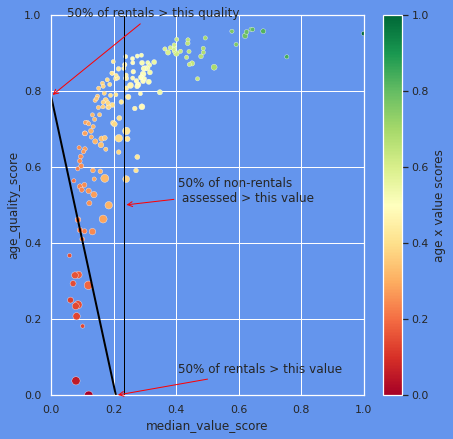

In [ ]:
import matplotlib as mpl
cmap = mpl.cm.cool
f, ax = plt.subplots(figsize=(7, 7))

norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

#cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                norm=norm,
#                                orientation='horizontal')
#cb1.set_label('Some Units')

sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

#ax.set(xscale='log',yscale='log')
sns.set_style("dark")
colors = rollup.pita_score.values

selection = rollup.query('group_name != "CAMBRIDGE RESIDENT" and group_name != "CAMBRIDGE_CLUB" and group_name != "WOODS_CROSSING"')
factor = 1.0

log_properties = selection.property_count.apply(lambda x: 10* pow((np.log10(x) +1),2)).values

sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
sns.scatterplot(data=selection,x='median_value_score',y='age_quality_score',hue='pita_score',palette="RdYlGn", size=log_properties)
plt.plot([0,median_value_per_unit*factor],[median_adjusted_age_quality*factor,0],linewidth=2,c='black')
plt.plot([residential_median,residential_median],[0,1],linewidth=1,c='black')

#plt.plot([0,adj_median_tax_value*factor],[non_rental_age_quality*factor,0],linewidth=2,c='green')#
ax.get_legend().remove()
plt.ylim(0.0, 1.0)
plt.xlim(0.0,1.0)
ax.figure.colorbar(sm, label='age x value scores')
plt.annotate('50% of rentals > this quality',xy=(0.0,median_adjusted_age_quality),
             xytext=(0.05,median_adjusted_age_quality + 0.2),
             arrowprops=dict(arrowstyle="->",color='red'),
             horizontalalignment='left',
             verticalalignment='bottom',)
plt.annotate('50% of rentals > this value',xy=(median_value_per_unit,0.0),
             xytext=(median_value_per_unit + 0.2, 0.05),
             arrowprops=dict(arrowstyle="->",color='red'),
             horizontalalignment='left',
             verticalalignment='bottom',)
plt.annotate('50% of non-rentals\n assessed > this value',xy=(residential_median,0.5),
             xytext=(median_value_per_unit + 0.2, 0.5),
             arrowprops=dict(arrowstyle="->",color='red'),
             horizontalalignment='left',
             verticalalignment='bottom',)
print("x=0", median_adjusted_age_quality*factor)
print("y=0", median_value_per_unit*factor)
plt.savefig('drive/My Drive/pita 2020/20200920-rental_quality.png')


In [ ]:
# y = mx + b : median_adjusted_age_quality
# b @ x = 0, median_adjusted_age_quality
# x = median_value_per_unit (actually value_score)
# m = -median_adjusted_age_quality/median_value_per_unit
# y < mx + b
# y-b = mx
# x < x * (y-b)/(y-b)
# m = (y-b)/x
# x = 0
b = median_adjusted_age_quality*factor
#y = 0
m = -1.0 * b/median_value_per_unit
print("y = {} x + {}".format(m,b))
pita = rollup.query('age_quality_score <= @m * median_value_score + @b')
#pita = selection.query('pita_score < 0.2 and avg_value_per_property < @median_tax_value').sort_values(by=['total_units','pita_score'],ascending=False)
print(len(pita))
pita

y = -3.789584021281797 x + 0.7860511199450052
13


,group_id,group_name,total_units,property_count,total_value,avg_value_per_property,avg_units_per_property,med_value_per_property,med_units_per_property,med_yrblt,avg_yrblt,med_property_sqft,avg_property_sqft,avg_quality_factor,med_quality_factor,avg_value_per_unit,med_value_per_unit,inv_avg_unit_value,med_age,adjusted_age_quality,age_quality_score,median_value_score,pita_score
0,0,MWB PROPERTIES LLC,99.0,73,3098333.0,4.244292e+04,1.356164,30600.0,1.0,1926.0,1933.506849,1120.0,1648.123288,6.977138,5.797308,31296.292929,30600.000000,1.020973e-09,94.0,0.516729,0.289095,0.119632,0.185971
1,1,SKINNERS COURT LLC,99.0,73,2296530.0,3.145932e+04,1.356164,30833.0,1.0,1948.0,1939.123288,1120.0,1563.369863,5.376496,4.121333,23197.272727,30833.000000,1.858344e-09,72.0,0.726861,0.000000,0.120543,0.000000
2,2,MADISON BAY HOLDINGS LLC,77.0,60,1558401.0,2.597335e+04,1.283333,20366.5,1.0,1930.0,1932.850000,1120.0,1460.050000,4.646111,4.128317,20238.974026,20366.500000,2.441310e-09,90.0,0.699193,0.038065,0.079624,0.055053
3,3,C/O THOMAS BRADLEY,62.0,54,1509503.0,2.795376e+04,1.148148,22050.0,1.0,1930.0,1934.481481,1120.0,1355.518519,4.965704,5.041819,24346.822581,22050.000000,1.687001e-09,90.0,0.553846,0.238030,0.086206,0.143246
9,9,CAMBRIDGE RENTALS LLC,39.0,29,971565.0,3.350224e+04,1.344828,20900.0,1.0,1926.0,1934.793103,1120.0,1559.448276,6.482258,4.499182,24911.923077,20900.000000,1.611334e-09,94.0,0.575897,0.207693,0.081710,0.130271
10,10,MCCOLLISTER TERRY A,30.0,23,673401.0,2.927830e+04,1.304348,20167.0,1.0,1915.0,1917.826087,1120.0,1460.869565,4.672584,4.451081,22446.700000,20167.000000,1.984701e-09,105.0,0.556521,0.234350,0.078844,0.135930
11,11,MARTINETTI PROPERTIES LLC,25.0,22,747868.0,3.399400e+04,1.136364,22500.0,1.0,1940.0,1936.409091,1120.0,1336.863636,6.839037,4.827752,29914.720000,22500.000000,1.117455e-09,80.0,0.496699,0.316652,0.087965,0.166896
13,13,B'S AND D'S RENTALS LLC,18.0,18,640599.0,3.558883e+04,1.000000,19550.0,1.0,1950.0,1956.500000,1120.0,1182.222222,7.536940,4.532378,35588.833333,19550.000000,7.895370e-10,70.0,0.497591,0.315424,0.076432,0.155269
17,17,KEYES DONALD H & ELIZABETH ANN,11.0,9,190133.0,2.112589e+04,1.222222,18000.0,1.0,1920.0,1922.222222,1120.0,1368.888889,4.225383,3.976285,17284.818182,18000.000000,3.347113e-09,100.0,0.513392,0.293686,0.070372,0.143761
18,18,JKL HOLDINGS LLC,9.0,9,156733.0,1.741478e+04,1.000000,15900.0,1.0,1930.0,1927.222222,1120.0,1120.000000,3.918215,3.585825,17414.777778,15900.000000,3.297343e-09,90.0,0.544991,0.250213,0.062162,0.124714


In [ ]:
pita.to_csv('drive/My Drive/pita 2020/20200920-lowest_rentals.csv')

In [ ]:
#group_df.query('group_name.str.contains("BRADLEY")',engine='python')
#group_df.query('group_id == 3')
print(len(output.query('LICENSE_TYPE != "RENTAL"')),pita.total_units.sum())

6326 626.0
